# Gradient Boosted Tree Model with XGBoost

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import to_graphviz
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import graphviz

**Note:** XGB can't work with Polars

In [52]:
X = pd.read_csv("Data/training_set_features.csv", index_col="respondent_id")

In [44]:
X=X[:].astype("category")

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

In [54]:
y1 = pd.read_csv("Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "h1n1_vaccine"])
y2 = pd.read_csv("Data/training_set_labels.csv", index_col="respondent_id", usecols=["respondent_id", "seasonal_vaccine"])

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=y1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.2, random_state=42, stratify=y2)

y1: h1n1 labels

y2: seasonal labels

In [55]:
estimators = [
    ('encoder', OrdinalEncoder()),
    #('clf', XGBClassifier(random_state=8, enable_categorical=True))
    ('clf', XGBClassifier(random_state=8))
]
northstream = Pipeline(estimators)
northstream

Pipeline(steps=[('encoder', OrdinalEncoder()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=8, ...))])

In [56]:
# Hyperparameter tuning
search_space = {
    'clf__max_depth': Integer(1, 6),
    'clf__learning_rate': Real(0.001, 1.0),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__alpha': Real(0.0, 1.0),
    'clf__lambda': Real(0.0, 1.0),
    'clf__gamma': Real(0.0, 1.0),
    #'sampling_method': Categorical('uniform'),
}

opt = BayesSearchCV(
    northstream,
    search_space,
    cv=5,
    n_iter=50,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)


In [57]:
opt.fit(X_train1, y_train1)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', OrdinalEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=...
                             'clf__gamma': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__lambda': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=1, high=6, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [58]:
opt.best_score_

0.8706970383841035

In [59]:
opt.score(X_test1, y_test1)

0.8598908469102785

In [17]:
opt.predict(X_test1)

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
opt.best_estimator_.steps[1][1].save_model("XGB_Model/xgb_new_h1n1_vaccine.model")

c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:49] WARNING: D:\bld\xgboost-split_1730232589250\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [26]:
opt.best_estimator_.steps[1][1].save_model("XGB_Model/xgb_new_h1n1_vaccine.json")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

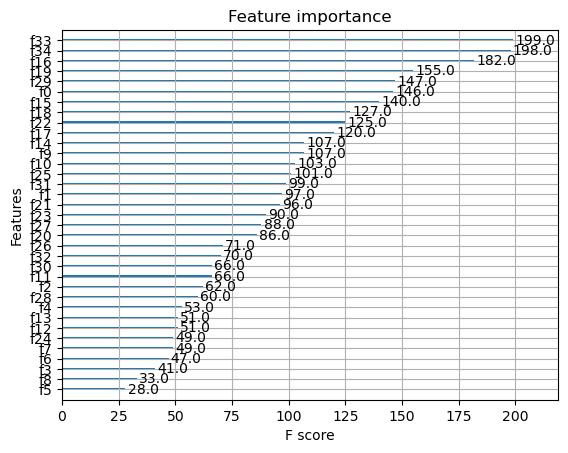

In [24]:
plot_importance(opt.best_estimator_.steps[1][1])

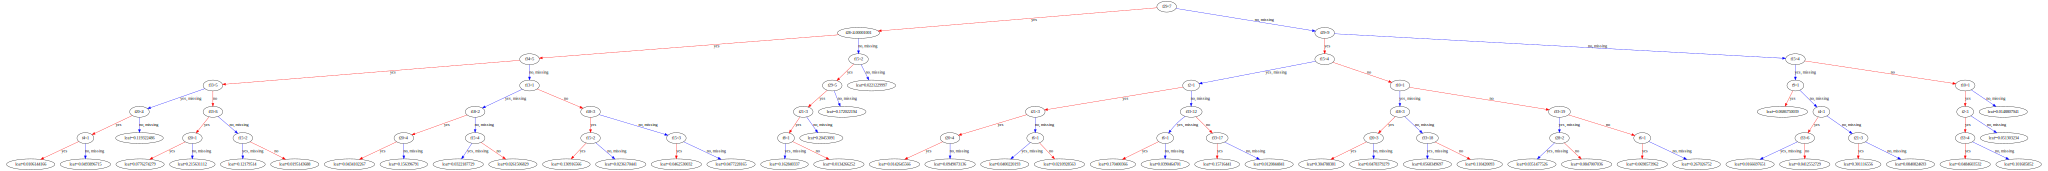

In [66]:
to_graphviz(opt.best_estimator_.steps[1][1], num_trees=30)

In [29]:
# Hyperparameter tuning
search_space = {
    'clf__max_depth': Integer(1, 6),
    'clf__learning_rate': Real(0.001, 1.0),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__alpha': Real(0.0, 1.0),
    'clf__lambda': Real(0.0, 1.0),
    'clf__gamma': Real(0.0, 1.0),
    #'sampling_method': Categorical('uniform'),
}

opt2 = BayesSearchCV(
    northstream,
    search_space,
    cv=5,
    n_iter=50,
    random_state=42,
    scoring='roc_auc',
    n_jobs=-1
)

In [30]:
opt2.fit(X_train2, y_train2)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('encoder', OrdinalEncoder()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=True,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=N...
                             'clf__gamma': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__lambda': Real(low=0.0, high=1.0, prior='uniform', transform='normalize'),
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=1, high=6, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [67]:
print("Best fitting score: ", opt2.best_score_)
print("Test score: ", opt2.score(X_test2, y_test2))

Best fitting score:  0.8616285820940937
Test score:  0.8651026669680587


In [68]:
opt2.predict(X_test1)

array([0, 1, 1, ..., 1, 0, 0])

In [70]:
opt2.best_estimator_.steps[1][1].save_model("XGB_Model/xgb_new_seas_vaccine.model")

c:\Users\sager\anaconda3\envs\polars_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:17:50] WARNING: D:\bld\xgboost-split_1730232589250\work\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [71]:
opt2.best_estimator_.steps[1][1].save_model("XGB_Model/xgb_new_seas_vaccine.json")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

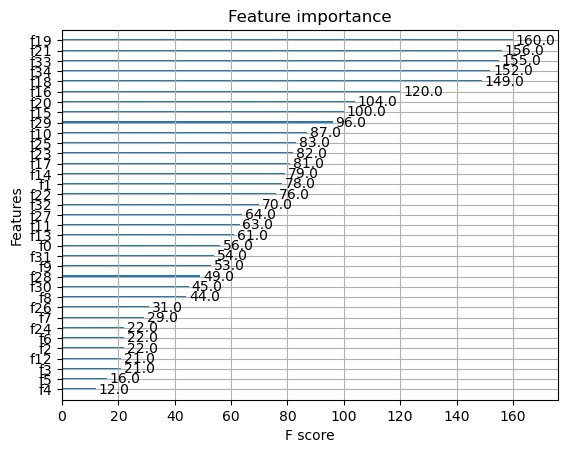

In [73]:
plot_importance(opt2.best_estimator_.steps[1][1])

# Submission Data

In [74]:
df_test_set_features = pd.read_csv('Data/test_set_features.csv', index_col='respondent_id')

In [92]:
null_h1n1_vaccine_probability=opt.predict_proba(df_test_set_features)
null_seas_vaccine_probability=opt2.predict_proba(df_test_set_features)

df_submission = df_test_set_features[[]]
df_submission['h1n1_vaccine'] = null_h1n1_vaccine_probability[:,1].tolist()
df_submission['seasonal_vaccine'] = null_seas_vaccine_probability[:,1].tolist()

C:\Users\sager\AppData\Local\Temp\ipykernel_13520\4247039381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['h1n1_vaccine'] = null_h1n1_vaccine_probability[:,1].tolist()
C:\Users\sager\AppData\Local\Temp\ipykernel_13520\4247039381.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission['seasonal_vaccine'] = null_seas_vaccine_probability[:,1].tolist()


In [94]:
df_submission.to_csv("XGB_Model/submission.csv")